
### Imports and Set Up

To run this notebook on your own you will need to the following libraries and API keys:

- [**pandas**](https://pypi.org/project/pandas/)
- [**python-dotenv**](https://pypi.org/project/python-dotenv/)
- [**langchain**](https://python.langchain.com/docs/how_to/installation/#official-release)
- [**langchain-community**](https://python.langchain.com/docs/how_to/installation/#integration-packages)
- [**langgraph**](https://python.langchain.com/docs/how_to/installation/#langgraph)
- [**openai**](https://pypi.org/project/openai/)
- [**langchain-openai**](https://python.langchain.com/docs/how_to/installation/#integration-packages)
- [*OPENAI_API_KEY*](https://openai.com/api/)

#### Install the libraries

Using pip

```bash
pip install pandas python-dotenv langchain langchain-community langgraph openai langchain-openai
```

Using [uv](https://docs.astral.sh/uv/)

```bash
uv venv;
source venv/bin/activate;
uv sync --extra openai
```


In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### Database Setup

The SQLite database used in this notebook is a locally stored subset of data that I have cleaned and preprocessed from the Office of Hawaiian Affairs' [Native Hawaiian Data Book 2023](https://ohadatabook.com/DB2023.html). It contains tables for the following datasets:

- **Population Estimates of the Hawaiian Islands: 1778‑1896**
- **Population of the Territory and State of Hawaii: US Census 1900-2020**
- **Native Hawaiian Population by States: US Census 2020**
- **Native Hawaiian Grandparents Living with Own Grandchildren: State of Hawaii 2010-2022**
- **Native Hawaiian Household Income by Selected Characteristics in the US and Hawaii: 2010-2022**
- **Native Hawaiian Families Below Poverty Level in the US and Hawaii: 2010-2022**
- **Employment of Civilian Native Hawaiians by Industry in the US and Hawaii: 2010‑2022**
- **Employment of Civilian Native Hawaiians by Occupation in the US and Hawaii: 2010‑2022**
- **Native Hawaiian School Enrollment in the State of Hawaii: 2010-2022**
- **Native Hawaiian Educational Attainment: State of Hawaii 2010-2022**

> **Note**: This is an initial attempt at structuring the original Excel sheets into a SQL database designed to work well with SQL Agents. After my initial exploration, I realized that the data structure, naming conventions, and labeling could be improved, which I plan to address in future iterations. No changes have been made yet as I want to establish a baseline for comparison with future versions.

In [2]:
from src.datacore.database import load_local_database

# Load the local database (i.e. `data/databases/local_database.db`)
db = load_local_database("local_database")

# List all the tables in the database to see what we have to work with
db.get_usable_table_names()

['hawaii_population',
 'native_hawaii_population_by_state_2020',
 'native_hawaiian_education_attainment_2010_2022',
 'native_hawaiian_employment_by_industry_2010_2022',
 'native_hawaiian_employment_by_occupation_2010_2022',
 'native_hawaiian_family_poverty_percentages_2010_2022',
 'native_hawaiian_grandparents_living_with_grandchildren_2010_2022',
 'native_hawaiian_household_income_2010_2022',
 'native_hawaiian_school_enrollment_2010_2022']

### LangGraph Setup
The below LLM SQL Agent Architecture closely follows LangGraph's [SQL Agent Tutorial](https://langchain-ai.github.io/langgraph/tutorials/sql-agent/), with some modifications to streamline the process.

In [3]:
from langchain_openai import ChatOpenAI

from src.llmcore.utils import handle_model_selection

CHAT_MODEL = ChatOpenAI
BASE_MODEL_CONFIG = {
    "model": handle_model_selection(CHAT_MODEL),
    "temperature": 0, # sets the randomness of the model; lower -> less random
}

BASE_MODEL_CONFIG

{'model': 'gpt-4o', 'temperature': 0}

In [4]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

from src.llmcore.tools import get_tool

# Get the SQLDatabaseToolkit from LangChain Community tools
toolkit = SQLDatabaseToolkit(
    db=db,
    llm=CHAT_MODEL(
        model=BASE_MODEL_CONFIG["model"],
    ),
)
tools = toolkit.get_tools()

# Get tools from the toolkit
list_tables_tool = get_tool(tools, "sql_db_list_tables")
get_schema_tool = get_tool(tools, "sql_db_schema")
db_query_tool = get_tool(tools, "sql_db_query")
query_check_tool = get_tool(tools, "sql_db_query_checker")

# Little test
print(list_tables_tool.invoke(""))
print(get_schema_tool.invoke("hawaii_population"))
print(db_query_tool.invoke("SELECT * FROM hawaii_population LIMIT 5"))

hawaii_population, native_hawaii_population_by_state_2020, native_hawaiian_education_attainment_2010_2022, native_hawaiian_employment_by_industry_2010_2022, native_hawaiian_employment_by_occupation_2010_2022, native_hawaiian_family_poverty_percentages_2010_2022, native_hawaiian_grandparents_living_with_grandchildren_2010_2022, native_hawaiian_household_income_2010_2022, native_hawaiian_school_enrollment_2010_2022

CREATE TABLE hawaii_population (
	year INTEGER NOT NULL, 
	total INTEGER, 
	percent_change REAL, 
	native_hawaiian INTEGER, 
	native_hawaiian_percent REAL, 
	non_native_hawaiian INTEGER, 
	non_native_hawaiian_percent REAL, 
	CONSTRAINT hawaii_population_pkey PRIMARY KEY (year)
)

/*
3 rows from hawaii_population table:
year	total	percent_change	native_hawaiian	native_hawaiian_percent	non_native_hawaiian	non_native_hawaiian_percent
1778	300000	None	None	None	None	None
1796	270000	-0.09999999999999998	None	None	None	None
1803	266000	-0.014814814814814836	None	None	None	None
*/


In [5]:
from src.llmcore.tools import create_tooled_agent

# Create agent tasked with checking queries
query_check_agent = create_tooled_agent(
    model=CHAT_MODEL(**BASE_MODEL_CONFIG),
    tools=query_check_tool,
    tool_choice="required",
)

# Little test for the newly created agent
incorrect_query = "SELECTs ** FROM hawaii_population LIMITING 5"
result = query_check_agent.invoke(incorrect_query)

print("Test query:", incorrect_query)
print("Result:", result.tool_calls[0]["args"]["query"])

Test query: SELECTs ** FROM hawaii_population LIMITING 5
Result: SELECT * FROM hawaii_population LIMIT 5


In [6]:
from langchain_core.messages import AIMessage

from src.llmcore.graph import SimpleGraphBuilder, SimpleState
from src.llmcore.tools import create_tool_call, create_tool_node
from src.llmcore.utils import State

### --- Create Base Graph --- ###

# Define a tool to list the tables in the database
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:  # noqa: ARG001
    """
    Call the list tables tool to get the tables in the database.
    """
    return create_tool_call(tool_name="sql_db_list_tables")

# Tool to choose tables based on table names' relevance to user query
model_get_schema = CHAT_MODEL(**BASE_MODEL_CONFIG).bind_tools([get_schema_tool])

# Initialize the graph with those nodes that can be add and
# connected sequentially and do not require any complex logic
graph = SimpleGraphBuilder(
    state=SimpleState,
    nodes=[
        (
            "first_tool_call",
            first_tool_call,
        ),
        (
            "list_tables_tool",
            create_tool_node([list_tables_tool]),
        ),
        (
            "model_get_schema",
            lambda state: {
                "messages": [model_get_schema.invoke(state["messages"])],
            },
        ),
        (
            "get_schema_tool",
            create_tool_node([get_schema_tool]),
        ),
    ],
    complete_build=False,
)

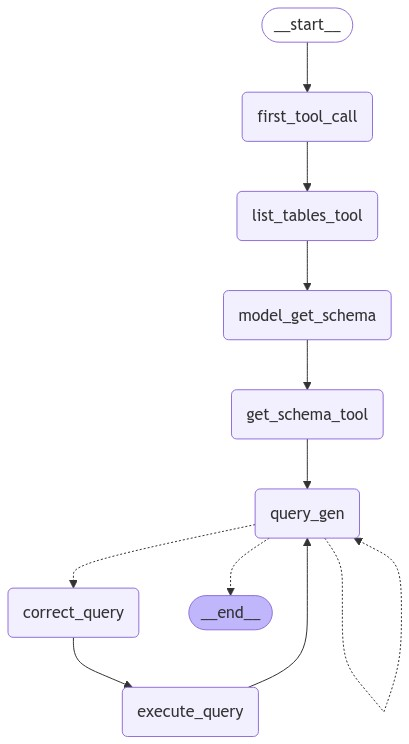

In [7]:
from typing import Literal

from langchain_core.messages import ToolMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph import END

from src.llmcore.prompts import QUERY_GENERATION_SYSTEM_PROMPT, SimpleChatPromptTemplate


### --- Add More Complex Logic --- ###
class SubmitFinalAnswer(BaseModel):
    """
    Submit the final answer to the user based on the query results.
    """

    final_answer: str = Field(..., description="The final answer to the user")


def query_gen_node(state: State) -> dict | None:
    """
    Generate a query based on the input question and schema.
    """
    message = query_gen.invoke(state)

    # Catch potential LLM hallucinations
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(  # noqa: PERF401
                    ToolMessage(
                        content=f"Error: The wrong tool was called {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    ),
                )
    else:
        tool_messages = []
    return {"messages": [message, *tool_messages]}


def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {"messages": [query_check_agent.invoke([state["messages"][-1]])]}


def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    """
    Decide whether to continue the workflow or end it.
    """
    messages = state["messages"]
    last_message = messages[-1]

    # If tool call then we finish
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    return "correct_query"


query_gen_prompt = SimpleChatPromptTemplate(
    system_prompt=QUERY_GENERATION_SYSTEM_PROMPT,
)
query_gen = query_gen_prompt | CHAT_MODEL(**BASE_MODEL_CONFIG).bind_tools([
    SubmitFinalAnswer,
])

graph.add_node("query_gen", query_gen_node)
graph.add_node("correct_query", model_check_query)
graph.add_node("execute_query", create_tool_node(db_query_tool))

graph.add_edge("get_schema_tool", "query_gen")
graph.add_conditional_edges("query_gen", should_continue)
graph.add_edge("correct_query", "execute_query")
graph.add_edge("execute_query", "query_gen")

### --- Compile Graph --- ###
app = graph.compile()
graph.show()

In [8]:
from pprint import pprint

from src.llmcore.utils import get_last_message

# Run the Agent
messages = app.invoke(
    {
        "messages": [
            (
                "user",
                "How educated are Native Hawaiians in Hawaii? How does this compare to the rest of Hawaii?",
            ),
        ],
    },
)

# Extract last message (i.e. the final answer)
last_message = get_last_message(messages)
pprint(last_message.tool_calls[0]["args"]["final_answer"])

('The education attainment data for Native Hawaiians in Hawaii is as follows:\n'
 '\n'
 '1. **Year 2010**:\n'
 '   - No High School Diploma: 8.8%\n'
 '   - High School Graduate: 45.5%\n'
 "   - Some College or Associate's Degree: 31.4%\n"
 "   - Bachelor's Degree: 10.1%\n"
 '   - Graduate or Professional Degree: 4.2%\n'
 '\n'
 '2. **Year 2011**:\n'
 '   - No High School Diploma: 8.6%\n'
 '   - High School Graduate: 43.9%\n'
 "   - Some College or Associate's Degree: 32.4%\n"
 "   - Bachelor's Degree: 9.9%\n"
 '   - Graduate or Professional Degree: 5.2%\n'
 '\n'
 '3. **Year 2012**:\n'
 '   - No High School Diploma: 10.2%\n'
 '   - High School Graduate: 42.4%\n'
 "   - Some College or Associate's Degree: 31.8%\n"
 "   - Bachelor's Degree: 10.4%\n"
 '   - Graduate or Professional Degree: 5.2%\n'
 '\n'
 'This data provides a snapshot of the education levels of Native Hawaiians in '
 'Hawaii over the years 2010 to 2012. For a detailed comparison with the rest '
 "of Hawaii, additional data 

In [9]:
from src.llmcore.utils import print_messages

# Print whole conversation
print_messages(messages)

================================ Human Message =================================

How educated are Native Hawaiians in Hawaii? How does this compare to the rest of Hawaii?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (tool_148)
 Call ID: tool_148
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

hawaii_population, native_hawaii_population_by_state_2020, native_hawaiian_education_attainment_2010_2022, native_hawaiian_employment_by_industry_2010_2022, native_hawaiian_employment_by_occupation_2010_2022, native_hawaiian_family_poverty_percentages_2010_2022, native_hawaiian_grandparents_living_with_grandchildren_2010_2022, native_hawaiian_household_income_2010_2022, native_hawaiian_school_enrollment_2010_2022
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_t9f3Am1fjKFKbr46lctPeb0y)
 Call ID: c

In [10]:
from src.datacore.database import load_df_from_local_database
from src.llmcore.utils import extract_sql_query

query = extract_sql_query(last_message.content)

df = load_df_from_local_database(
    "local_database",
    query = query,
)
df.head()

year  percent_no_high_school_diploma  percent_high_school_graduate  \
0  2010                           0.088                         0.455   
1  2011                           0.086                         0.439   
2  2012                           0.102                         0.424   
3  2013                           0.076                         0.427   
4  2014                           0.075                         0.435   

   percent_some_college_or_associates  percent_bachelors  \
0                               0.314              0.101   
1                               0.324              0.099   
2                               0.318              0.104   
3                               0.325              0.121   
4                               0.326              0.116   

   percent_graduate_or_professional_degree  
0                                    0.042  
1                                    0.052  
2                                    0.052  
3                                    0.051  
4                                    0.048